# centreOptimiser

Once you have created your geometry via geoAssembler, there's a good chance that the centre of the geometry is not the centre of the beam. This can very negatively effect the results of azimuthal integration, or any other form of analysis which requires precise knowledeg of the centre of the beam.

centreOptimiser was created to solve this problem, it uses data from sharp diffraction rings (e.g. from Lithium Titanate powder) to improve the geometry further.

It can be imported from geoAssembler as:

In [1]:
from geoAssembler.optimiser import CentreOptimiser

From here import all of the packages you would normally use:

In [2]:
from extra_data import RunDirectory, stack_detector_data
from extra_geom import AGIPD_1MGeometry

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import os.path

Now create a geomtery and run object:

In [5]:
geom = AGIPD_1MGeometry.from_quad_positions(quad_pos=[
        (-525, 625),
        (-550, -10),
        (520, -160),
        (542.5, 475),
    ])

In [6]:
run_path = '/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/'
run_available = os.path.isdir(run_path)
if run_available:
    run = RunDirectory('/gpfs/exfel/exp/SPB/201831/p900039/proc/r0273/')
else:
    print("Run not available, falling back to using saved frame")

centreOptimiser takes in stacked detector data (e.g. [16, 512, 128] for AGIPD), but passing just a single pulse throgh probably won't give the best results.

Instead, you should take an average of a few pulses, do some correction using the mask values, and mask off the edges of the ASICs as they are double wide and should either be corrected for or excluded. The following either does this, if the data is available, or loads in some example corrected stacked data:

In [7]:
if run_available:
    train_index = 60

    run = run.select('*/DET/*', 'image.*')
    train_data = run.train_from_index(train_index)[1]

    # We avoid the first/last pulses, as in this case they are of worse quality than
    # the other pulses 
    stacked_image = stack_detector_data(train_data, 'image.data')[10:-10]
    stacked_mask = stack_detector_data(train_data, 'image.mask')[10:-10]

    # Any non-zero masks are set to nan
    stacked_image[stacked_mask > 0] = np.nan

    # Sub-zero and very large values set to nan
    stacked_image[stacked_image < 0] = np.nan
    stacked_image[stacked_image > 1e5] = np.nan

    stacked_mean = np.nanmean(stacked_image, axis=0)
    stacked_mean = np.clip(stacked_mean, 0, 1024)

    # ASIC edges have double pixels, we can mask those off here
    edge_mask = np.full((8, 16, 512//8, 128), np.nan)
    edge_mask[:, :, 1:-1, :] = 1
    edge_mask = edge_mask.reshape((16, 512, 128))

    stacked_mean = stacked_mean * edge_mask
else:
    print("Run not available, falling back to using saved frame")
    saved_frame_path = os.path.join(
        os.path.dirname(centreOptimiser.__file__), "..", "tests", "optimiser-test-frame.npy")
    frame = np.load(saved_frame_path)

Creating the optimiser requires the geometry object, the frame, and the distance to the samlpe in m:

In [8]:
optimiser = CentreOptimiser(geom, stacked_mean, sample_dist_m=0.2)

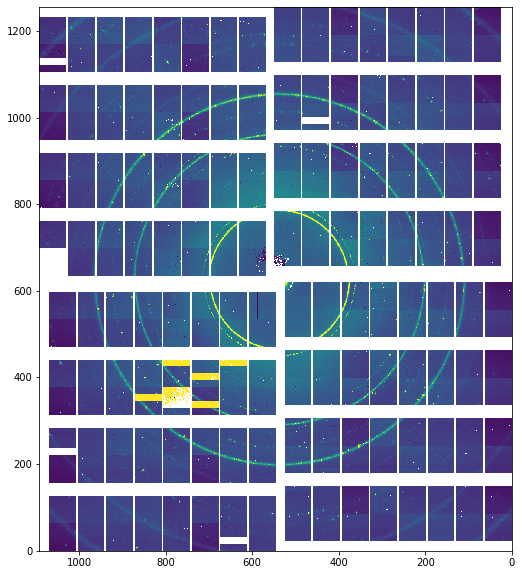

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(optimiser.frame, origin='lower', interpolation='none')
plt.gca().invert_xaxis()

The optimiser can then perform '2d integration', which just unrolls the frame around the centre:

In [10]:
integrate2d_result = optimiser.integrate2d(optimiser.frame)
misaligned_2dint = integrate2d_result.intensity
misaligned_2dint_r = integrate2d_result.radial
misaligned_2dint_a = integrate2d_result.azimuthal

#  Ignoring the first/last 100 radial pixels as these regions are very
#  distorted, and the integration results there are not reliable
misaligned_1dint = np.nanmean(misaligned_2dint, axis=0)[100:-100]
misaligned_1dint_x = integrate2d_result.radial[100:-100]

In [11]:
brightest_ring_idx = np.where(misaligned_1dint == np.nanmax(misaligned_1dint))[0][0] + 100

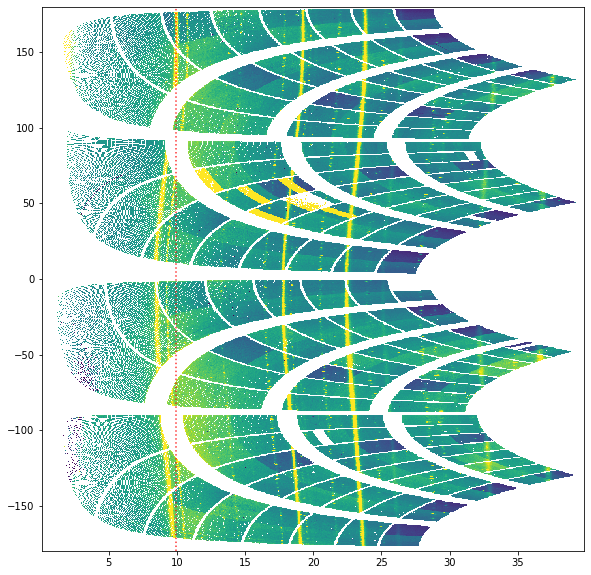

In [12]:
plt.figure(figsize=(12, 10))
plt.imshow(np.clip(misaligned_2dint, 0, 600),
    extent=(
        min(misaligned_2dint_r), max(misaligned_2dint_r),
        min(misaligned_2dint_a), max(misaligned_2dint_a)
    ),
   aspect=(max(misaligned_2dint_r)/max(misaligned_2dint_a)/2),
   interpolation='nearest'
)
plt.axvline(misaligned_2dint_r[brightest_ring_idx], color='r', linestyle=':', alpha=0.8)

Above you can see that the circular diffraction rings are now lines, however these lines are slightly curved/wavy. This wavyness indicates that the centre of the geometry is not the same as the centre of the diffraction rings.

Performing azimuthal integration when the centre is not correct will smear out the rings over a wide area, reducing the overall signal and very negatively affecting the results you receive:

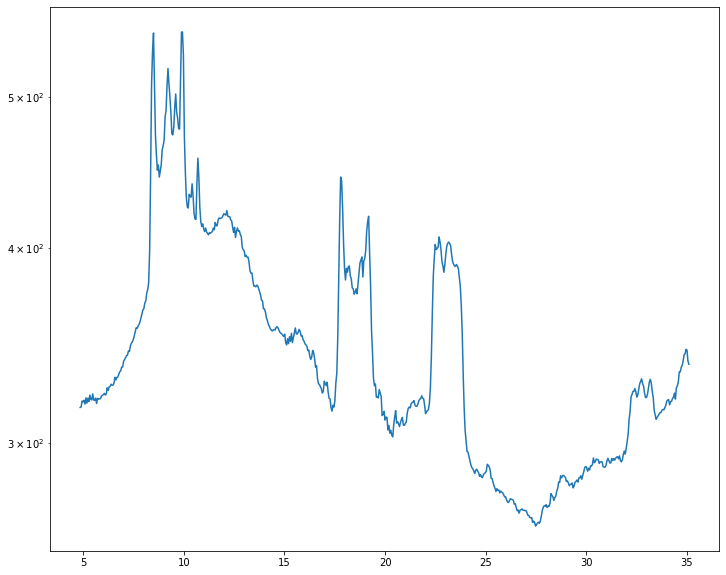

In [13]:
plt.figure(figsize=(12, 10))
plt.plot(misaligned_1dint_x, misaligned_1dint)
plt.yscale('log')

To correct for this, call the `optimise` method of the optimiser object:

In [14]:
%%time
res = optimiser.optimise(workers=1) # Single process

Optimal quad positions:  [
    (-512.3193128771519, 629.778223948041),
    (-537.3193128771519, -5.221776051958928),
    (532.6806871228481, -155.22177605195893),
    (555.1806871228481, 479.77822394804105),
]
CPU times: user 4min 32s, sys: 711 ms, total: 4min 33s
Wall time: 4min 34s


In [15]:
%%time
# Optionally - **if you are running this on  a dedicated node**
# you can set workers to the number of parallel processes you
# want to use, or set it to -1 to use as many processes as possible
res = optimiser.optimise(workers=-1) # Parallel

Optimal quad positions:  [
    (-512.2172882372101, 629.7052090687166),
    (-537.2172882372101, -5.29479093128343),
    (532.7827117627899, -155.29479093128344),
    (555.2827117627899, 479.70520906871656),
]
CPU times: user 17.2 s, sys: 20.3 s, total: 37.5 s
Wall time: 1min 4s


The optimiser works by maximising the peak value of the 1D integration result. When this is maximised it means that the diffraction rings are as straight as they can be in the azimuthal view, which means that the centre is close to the actual centre of the rings.

The output of the optimisationis an object which contains the corrected quadrant corner positions, optimal centre offset, as well as all of the result object of the scipy optimiser.

You can now use the optimal quad positions to create a corrected geometry:

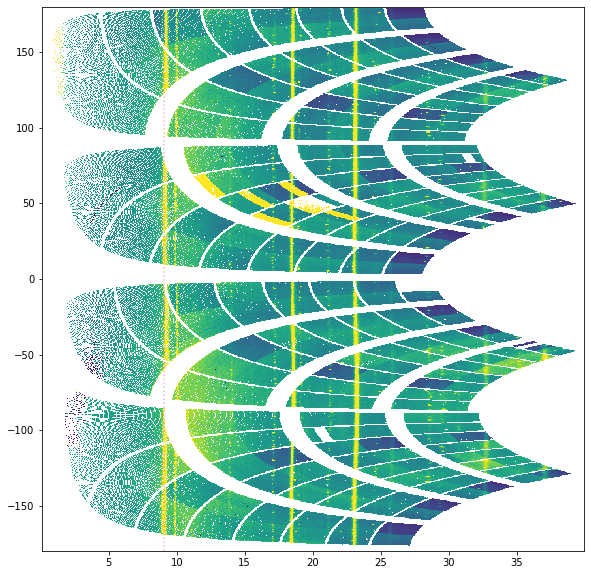

In [16]:
corrected_geom = AGIPD_1MGeometry.from_quad_positions(
    quad_pos=res.optimal_quad_positions
)

corrected_optimiser = CentreOptimiser(corrected_geom, stacked_mean, sample_dist_m=0.2)

corrected_integrate2d_result = corrected_optimiser.integrate2d(corrected_optimiser.frame)
corrected_2dint = corrected_integrate2d_result.intensity
corrected_2dint_r = corrected_integrate2d_result.radial
corrected_2dint_a = corrected_integrate2d_result.azimuthal

corrected_1dint = np.nanmean(corrected_2dint, axis=0)[100:-100]
corrected_1dint_x = optimiser.integrate2d(corrected_optimiser.frame).radial[100:-100]

brightest_ring_idx = np.where(corrected_1dint == np.nanmax(corrected_1dint))[0][0] + 100

plt.figure(figsize=(12, 10))
plt.imshow(np.clip(corrected_2dint, 0, 600),
    extent=(
        min(corrected_2dint_r), max(corrected_2dint_r),
        min(corrected_2dint_a), max(corrected_2dint_a)
    ),
   aspect=(max(corrected_2dint_r)/max(corrected_2dint_a)/2),
   interpolation='nearest'
)
plt.axvline(misaligned_2dint_r[brightest_ring_idx], color='r', linestyle=':', alpha=0.3)

As you can see, the wavy lines are now much straighter. Performing azimuthal integration on this will now show:

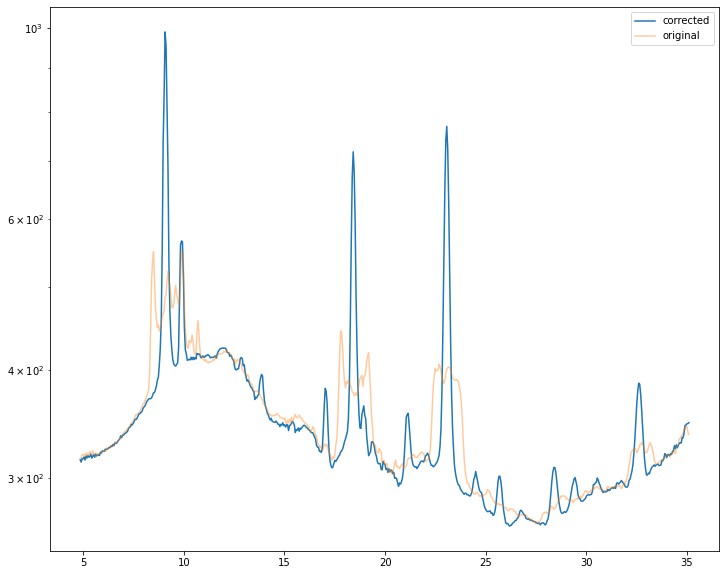

In [17]:
plt.figure(figsize=(12, 10))
plt.plot(misaligned_1dint_x, (np.nanmean(corrected_2dint, axis=0)[100:-100]), label="corrected")
plt.plot(misaligned_1dint_x, (misaligned_1dint), label="original", alpha=0.4)
plt.yscale('log')
plt.legend()

Which is a massive improvement over the previous result.